# 4. Time-varying beta functions

Far from being limited to static beta values, we can also simulate the affects of a time-and-location-varying beta function. For this demo, we'll use the State-level geo scope we defined in Part 2.

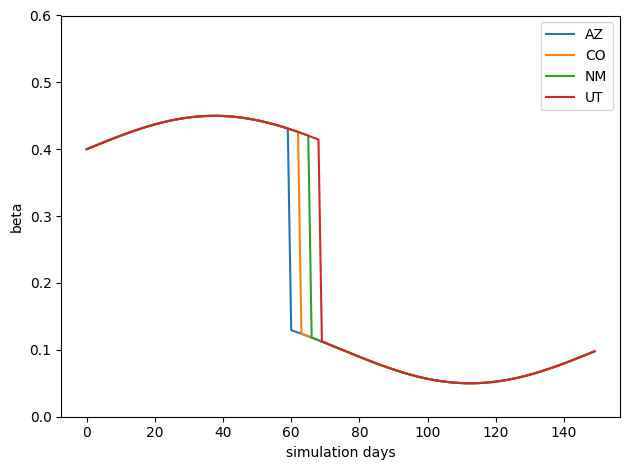

In [1]:
from math import pi, sin

import matplotlib.pyplot as plt

from epymorph.kit import *
from epymorph.adrio import acs5, commuting_flows, us_tiger


class Beta(ParamFunctionTimeAndNode):
    # Our function will be a sinusoid with a precipitous drop after 60 days,
    # staggered by 3 days for each location.

    def evaluate1(self, day, node_index):
        # The arguments of this function are
        # `day` -- the current simulation day, and
        # `node_index` -- the current geo node.
        # This formuluation allows us to vary the parameter over time and geo node.
        total_days = self.time_frame.days
        value = 0.40 + 0.05 * sin(2 * pi * day / total_days)
        cutoff = 60 + (node_index * 3)
        if day >= cutoff:
            value -= 0.30
        return value


# We would like to check that our function is what we expect,
# so let's evaluate it so we can see it on a plot.

# In order to do this, we have to assemble the parts of the simulation context
# that our function needs to compute its values. In this case, those are
# the simulation dimensions and the geographic scope.
scope = StateScope.in_states(["AZ", "NM", "CO", "UT"], year=2020)
time_frame = TimeFrame.of("2015-01-01", 150)

dim = SimDimensions.build(
    # These are the real (required) values:
    start_date=time_frame.start_date,
    days=time_frame.duration_days,
    nodes=scope.nodes,
    # And these are placeholders, because they're not used by our function:
    tau_step_lengths=[1],
    compartments=1,
    events=1,
)

# Instantiate our function, provide context to it, and evaluate.
# That gives us the TxN series of beta values as a numpy array.
beta_values = Beta().with_context(scope=scope, time_frame=time_frame).evaluate()

fig, ax = plt.subplots()
ax.set_ylim(0.0, 0.6)
ax.set(ylabel="beta", xlabel="simulation days")
ax.plot(beta_values, label=scope.labels)
ax.legend()
fig.tight_layout()
plt.show()

Loading epymorph.adrio.commuting_flows.Commuters:
  |####################| 100%  (8.948s)
Loading epymorph.adrio.acs5.Population:
  |####################| 100%  (1.118s)
Loading epymorph.adrio.us_tiger.Name:
  |####################| 100%  (0.166s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-30 (150 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.309s


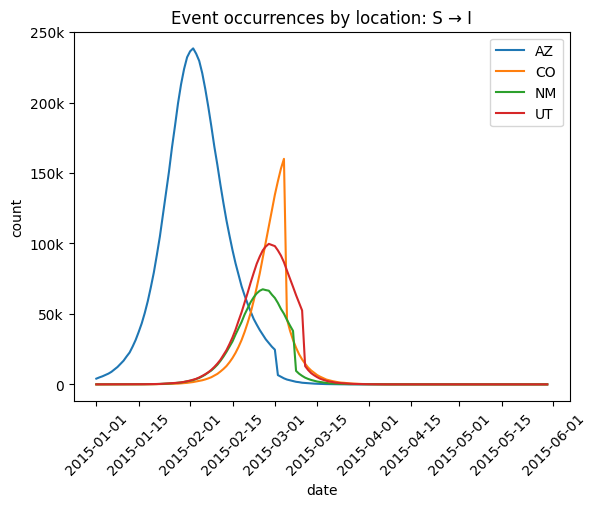

In [2]:
# Now we create a simulation, passing in our beta function.
# To make sure our simulation executes with the same beta values
# shown in the plot, make sure to use the same geo scope and time frame.
rume = SingleStrataRume.build(
    ipm=ipm.Sirh(),
    mm=mm.Pei(),
    scope=scope,  # from above
    params={
        "beta": Beta(),
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "move_control": 0.9,
        "theta": 0.1,
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=time_frame,  # from above
    # Initialize the infection in Arizona with 10k individuals.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

output.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    title="Event occurrences by location: S → I",
    label_format="{n}",
)